In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# changing matplotlib the default style
matplotlib.style.use('ggplot')

from PDB_Order_Fixer import PDB_Order_Fixer
import mdtraj as md
import os
import numpy as np
import h5py

import datetime
import glob
import copy
from functools import partial 
import operator
import time

import random 
import subprocess
from subprocess import Popen
import sys
from io_functions import *
from custom_clusterer import *
from custom_tica import *
from custom_featurizer import *
from pdb_editing import *
from analysis import *
from io_functions import *
#from topology_fixing import *
from subsampling import *
from conversions import *
from custom_msm import *
from grids import *
from docking_analysis import *

In [ ]:
from operator import itemgetter

In [ ]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In this iPython notebook, we will featurize MOR ligand binding simulation by pairwise distances between the ligand and different receptor residues. We will then perform tICA and prospectively build an MSM. 

In [ ]:
from detect_intermediates import *
from interpret_tICs import *

In [ ]:
from mor_h8_feature_types import *
from get_variable_names import *
from mor_h8_tica_config import *
from residue import Residue, Atom
ori_feature_name = copy.deepcopy(feature_name)

In [ ]:
rho = 0.1
rho_string = "0pt1"
lag_time = 5
n_components = 10
n_clusters = 1000

rho = 0.01
rho_string = "0pt01"
lag_time=50

In [ ]:
schemes = ["closest-heavy", "CA"]
feature_name = "%s-CA" %ori_feature_name
#feature_name = "%s_phi_psi_chi2" %feature_name
(active_ref_dir, inactive_ref_dir, simulation_ref_dir, scripts_dir,
          ligand_dir, agonist_dir, inverse_agonist_dir, biased_agonist_dir, ref_receptors_dir, whole_trajectory_pnas,
          sasa_file) = get_base_files(base)

tica_dir = get_tica_dir(base, is_sparse, lag_time, n_components, feature_name, 
                                 wolf_string, shrinkage_string, rho_string)
tica_dir = "%s-with-inactive" %tica_dir
ori_tica_dir = copy.deepcopy(tica_dir)
#tica_dir = "%s-normalized" % ori_tica_dir
features_dir = get_features_dir(base, feature_name)

landmarks_dir = get_landmarks_dir(tica_dir)
analysis_dir = get_analysis_dir(tica_dir, n_clusters, sampling_method)
gmm_dir = get_gmm_dir(tica_dir)
rf_dir = get_rf_dir(tica_dir)


ref_tica_dir, ref_tica_coords = get_ref_tica_dirs(tica_dir)

graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)

pnas_titles =  ["tm6_tm3_dist", "rmsd_npxxy_inactive", "rmsd_npxxy_active", "rmsd_connector_inactive", "rmsd_connector_active"]
pnas_features_dir = analysis_dir


(clusterer_dir, msm_model_dir, macrostate_dir, features_known, model_dir, projected_features_dir,
         projection_operator_dir, ktica_fit_model_filename, ktica_projected_data_filename, nystroem_data_filename,
         mutual_information_csv, pearson_csv) = get_tica_files(base, tica_dir, n_clusters, msm_lag_time, n_macrostates)

(standardized_features_dir, feature_residues_csv, feature_residues_pkl,
          contact_csv, ref_features_dir) = get_feature_files(features_dir)

(kmeans_csv, tica_coords_csv, features_csv, active_rmsd_dir, inactive_rmsd_dir, active_pnas_dir, inactive_pnas_joined, active_pnas_joined,
        clusters_map_file, ktica_clusters_map_file, analysis_file, combined_file, docking_summary, docking_joined, docking_z_scores_csv,
        aggregate_docking, aggregate_docking_joined, docking_pnas_joined, aggregate_docking_pnas, aggregate_docking_pnas_joined, docking_multiple_ligands,
        docking_distances_file, docking_pdf, mmgbsa_docking_distances, pnas_coords, mmgbsa_dir, mmgbsa_csv, mmgbsa_pdf, aggregate_mmgbsa,
        aggregate_mmgbsa_joined, aggregate_mmgbsa_pnas_joined, mmgbsa_z_scores_csv, active_clusters_csv, intermediate_clusters_csv,
        inactive_clusters_csv, pnas_clusters_averages, tica_clusters_averages, tica_classes_csv, tica_samples_csv, subgraph_save_base,
        degree_save_base, degree_map_csv, degree_z_map_csv, aggregate_docking_pnas_degree_z_joined, tic_residue_csv, feature_coefs_csv,
        duplicated_feature_coefs_csv) = get_analysis_files(analysis_dir, n_clusters, tica_dir, tica_dir, sampling_method, n_samples, precision,
                                                           msm_lag_time)

(inactive_pnas_distances_dir, active_pnas_distances_dir, active_pnas_all_distances_dir,
          inactive_pnas_distances_new_csv, active_pnas_distances_new_csv, active_pnas_joined, active_pnas_means, pnas_coords_dir,
          pnas_coords_csv, pnas_all_coords_csv, pnas_coords_hexbin_dir, pnas_coords_co_crystallized_docking_dir,
          pnas_coords_active_colors_dir, user_defined_features_file, reaction_coordinates_trajs_file) = get_pnas_files(whole_trajectory_pnas, pnas_features_dir)

features_dir = get_features_dir(base, feature_name)



graph_file = get_graph_file(tica_dir, msm_lag_time, n_clusters)
(scripts_dir, pymol_fixpdb_dir) = get_script_dir(scripts_dir)
(save_dir, reimaged_dir, mae_dir, combined_reimaged_dir, grid_dir, docking_dir) = get_docking_dirs(tica_dir, n_clusters, n_components, n_samples, sampling_method, precision)


In [ ]:
from ipyparallel import Client
rc = Client()
print(len(rc.ids))
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

In [ ]:
tica_dir

In [ ]:
feature_name_residues_dict.keys()

In [ ]:
contact_residues

In [ ]:
import custom_featurizer
reload (custom_featurizer)
from custom_featurizer import *
suf_trajectories = [t for t in get_trajectory_files(traj_dir, ".h5") if "suf" in t and "re" in t]
fix_chain_names(suf_trajectories, dview)
#featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[inactive_dir, active_dir], contact_residues=contact_residues,
#                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
#                          user_specified_atom_residue_pairs = [], load_from_file=False, worker_pool=None, schemes=schemes)

In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
user_defined_features_dir = "%s/user_defined_features" %traj_dir
if not os.path.exists(user_defined_features_dir):
    os.makedirs(user_defined_features_dir)
compute_user_defined_features_wrapper(traj_dir, traj_ext, inactive_dir, active_dir, None,
                                        feature_name_residues_dict, user_defined_features_file, worker_pool=dview, 
                                        save_dir=user_defined_features_dir, parallel=False)

In [ ]:
type(contact_residues[0])

In [ ]:
traj_dir = "/home/enf/md_simulations/MOR/h8_reimaged/trajectories"

In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *
featurize_contacts_custom(traj_dir, features_dir = features_dir, traj_ext = traj_ext, contact_residue_pairs_file = feature_residues_pkl, structures=[inactive_dir, active_dir], contact_residues=contact_residues,
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = [], load_from_file=False, worker_pool=dview, schemes=schemes)

In [ ]:
fit_normalizer(features_dir)

In [ ]:
import pickle
with open(feature_residues_pkl, "rb") as f:
    feature_residues = pickle.load(f)

In [ ]:
feature_residues

In [ ]:
import custom_tica
reload(custom_tica)
from custom_tica import *
fit_and_transform(features_directory = features_dir, model_dir = tica_dir, stride=5, lag_time = lag_time, n_components = n_components, sparse = sparse, wolf = wolf, rho = rho, shrinkage = shrinkage, parallel=True, traj_ext = traj_ext, normalize=True, partial_fit=True)

In [ ]:
import custom_featurizer
reload(custom_featurizer)
from custom_featurizer import *

featurize_contacts_custom(ref_receptors_dir, features_dir = ref_features_dir, traj_ext = ".pdb", contact_residue_pairs_file = feature_residues_pkl, structures=[inactive_dir, active_dir], contact_residues=contact_residues,
                          residues_map = None, contact_cutoff = cutoff, parallel = False, exacycle = exacycle, traj_top_structure = None, iterative=False,
                          user_specified_atom_residue_pairs = [], load_from_file=False, worker_pool=dview, schemes=schemes)

In [ ]:
ref_features = [load_file(f) for f in get_trajectory_files(ref_features_dir, ".dataset")]
print(len(ref_features))
print(ref_features[0].shape)
print(ref_features[1].shape)
print(len(feature_names))
ref_features = pd.DataFrame(ref_features[0], columns=[str(f) for f in feature_names])

In [ ]:
transform(existing_model = projection_operator_dir, features_directory = ref_features_dir, tica_dir = ref_tica_dir, normalizer=verboseload("%s/normalizer.h5" %features_dir))


In [ ]:
import custom_tica
reload(custom_tica)
from custom_tica import *
transform_to_h5(projection_operator_dir, features_dir, projected_features_dir, worker_pool=None, parallel=True, normalizer=verboseload("%s/normalizer.h5" %features_dir))

In [ ]:
tica_object = verboseload(projection_operator_dir)

In [ ]:
#all_tica = verboseload(projected_features_dir)
#all_tica = [x[:,range(1,10)] for x in all_tica]
#print(all_tica[0].shape)
#print(len(all_tica))
#verbosedump(all_tica, projected_features_dir)


In [ ]:
#n_components=9

In [ ]:
tica_object.timescales_

In [ ]:
plot_columns(tica_dir, projected_features_dir, titles = ["tIC%d" %j for j in range(1,11)], tICA = True, scale = 1.0, refcoords_file = None)

In [10]:
feature_indices = []
traj_basenames = get_trajectory_files(traj_dir, ".h5")
traj_basenames = [os.path.splitext(os.path.basename(t))[0] for t in traj_basenames]
feature_basenames = get_trajectory_files(features_dir, ".dataset")
feature_basenames = [os.path.splitext(os.path.basename(t))[0] for t in feature_basenames]
for i, traj_basename in enumerate(traj_basenames):
    if traj_basename in feature_basenames:
        feature_indices.append(int(i))

In [11]:
#tica_coords = verboseload(projected_features_dir)
pnas_coords = verboseload(user_defined_features_file)
pnas_coords = [pnas_coords[i] for i in feature_indices]
#tica_names = ["tIC.%d" %i for i in range(1,n_components+1)]
pnas_names = sorted(feature_name_residues_dict.keys())

loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5"...


In [12]:
#print(np.concatenate(tica_coords).shape)
print(np.concatenate(pnas_coords).shape)

(803693, 11)


In [ ]:
from plots import *

In [ ]:
plot_data_vs_data(np.concatenate(tica_coords), np.concatenate(pnas_coords), tica_names, pnas_names, analysis_dir)

In [ ]:
tica_coords = verboseload(projected_features_dir)
np.shape(np.concatenate(tica_coords))

In [ ]:
f = load_file("/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/apo_rep_167.dataset")

In [ ]:
np.shape(f)

In [ ]:
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)

In [13]:
with open(feature_residues_pkl) as f:
    feature_names = pickle.load(f)
print(feature_names[0].__repr__())

ILE193 to ILE198


In [ ]:
from residue import *
print(type(feature_names[0]))
print(type(feature_names[0] == DihedralFeature))


In [ ]:
np.concatenate(suf_tica).shape

## 

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_components_dir = tica_dir
important_contact_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=n_components, percentile=95)


In [ ]:
tic_components_dir = tica_dir
important_contact_features = interpret_tIC_components(projection_operator_dir, tic_components_dir, feature_residues_pkl, n_tica_components=n_components, percentile=95)



In [ ]:
important_contact_features[0]

In [ ]:
import interpret_tICs
reload(interpret_tICs)
from interpret_tICs import *
tic_subsampled_features_file = "%s/features_subsampled.pkl" % tica_dir
subsampled_features_dir = os.path.join(tica_dir, "subsampled_features")
if not os.path.exists(subsampled_features_dir): os.makedirs(subsampled_features_dir)
important_contact_features_pruned, important_contact_features_indices = find_non_zero_features(important_contact_features[0], feature_names)
#subsample_features(features_dir, important_contact_features_indices, important_contact_features_pruned, tic_subsampled_features_file)

In [ ]:
important_contact_features_pruned

In [ ]:
protein_top_features = load_file(tic_subsampled_features_file)



In [ ]:
protein_top_features[0].iloc[0]

In [ ]:
f = load_file("/home/enf/md_simulations/MOR/h8_reimaged/featuresall_residues_4dkl_5c1m_under_cutoff6A-CA/apo_rep_1.dataset")
np.shape(f)

In [ ]:
from ipyparallel import Client
rc = Client()
dview = rc[:]
dview.map(os.chdir, ['/home/enf/b2ar_analysis/conformation']*len(rc.ids))

print(len(rc.ids))


In [14]:
bu72_trajs = []
apo_trajs = []
oxy_trajs = []
suf_trajs = []
trv_trajs = []
trajs = get_trajectory_files(features_dir, ".dataset")
#trajs = [t for t in get_trajectory_files(traj_dir, traj_ext) if "apo_reimaged" not in t and "oxy" not in t]
for i, traj in enumerate(trajs):
    if "bu72" in traj or "Rep" in traj:
        bu72_trajs.append(i)
    elif "apo" in traj:
        apo_trajs.append(i)
    elif "oxy" in traj:
        oxy_trajs.append(i)
    elif "suf" in traj:
        suf_trajs.append(i)
    elif "trv" in traj:
        trv_trajs.append(i)

user_defined_coords = load_file(user_defined_features_file)

            

loading /home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5
loading "/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/user_defined_features.h5"...


In [15]:
bu72_pnas = [user_defined_coords[i] for i in bu72_trajs]
apo_pnas = [user_defined_coords[i] for i in apo_trajs]
oxy_pnas = [user_defined_coords[i] for i in oxy_trajs]
suf_pnas = [user_defined_coords[i] for i in suf_trajs]

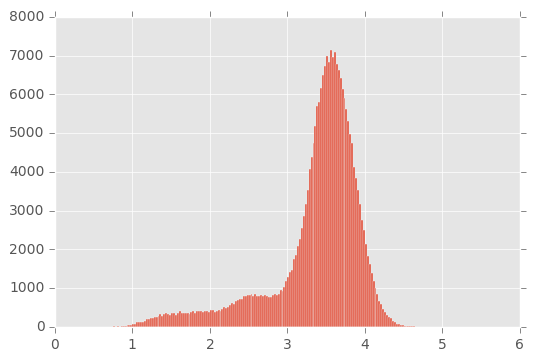

In [35]:
plt.clf()
plt.hist(np.concatenate(apo_pnas)[:,2], bins=200, range=[0,5])
plt.show()

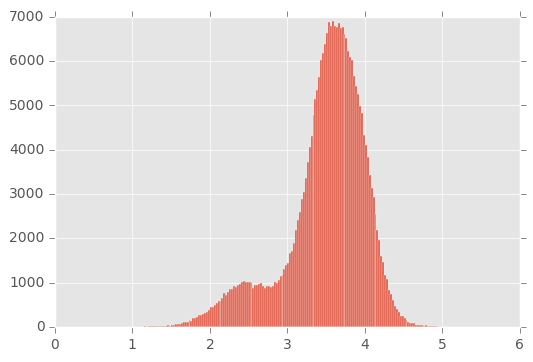

In [36]:
plt.clf()
plt.hist(np.concatenate(suf_pnas)[:,2], bins=200, range=[0,5])
plt.show()

In [24]:
np.concatenate(suf_pnas).shape

(272021, 11)

In [18]:
sorted(feature_name_residues_dict.keys())

['res_277_res_339_ca_dist',
 'rmsd_DRY_active',
 'rmsd_DRY_inactive',
 'rmsd_npxxy_active',
 'rmsd_npxxy_inactive',
 'rmsd_triad_active',
 'rmsd_triad_inactive',
 'tm6_tm3_dist',
 'tm6_tm3_packing',
 'tm6_tm5_packing',
 'tm6_tm7_packing']

In [ ]:
bu72_pnas_file = "%s/bu72.h5" % whole_trajectory_pnas
apo_pnas_file = "%s/apo.h5" % whole_trajectory_pnas
#oxy_pnas_file = "%s/oxy.h5" % whole_trajectory_pnas
suf_pnas_file = "%s/suf.h5" % whole_trajectory_pnas

In [ ]:
from imp import reload
import analysis
reload(analysis)
from analysis import *
import seaborn as sns
bu72_pnas_concatenated = np.concatenate(bu72_pnas)
print(np.shape(bu72_pnas_concatenated))
apo_pnas_concatenated = np.concatenate(apo_pnas)
#oxy_pnas_concatenated = np.concatenate(oxy_pnas)
suf_pnas_concatenated = np.concatenate(suf_pnas)




verbosedump(bu72_pnas, bu72_pnas_file)
verbosedump(apo_pnas, apo_pnas_file)
#verbosedump(oxy_pnas, oxy_pnas_file)
verbosedump(suf_pnas, suf_pnas_file)





columns=sorted(feature_name_residues_dict.keys())
#plot_columns(whole_trajectory_pnas, bu72_pnas_file, titles=columns, main = "BU72", tICA = False, scale = 1.0, refcoords_file = None)
#plot_columns(whole_trajectory_pnas, apo_pnas_file, titles=columns, main = "Apo", tICA = False, scale = 1.0, refcoords_file = None)

#df = pd.DataFrame(bu72_pnas_concatenated, columns=sorted(feature_name_residues_dict.keys()))
#sns.jointplot(x="tm6_tm3_dist", y="rmsd_npxxy_inactive", data=df, kind="kde")
#plt.hexbin(bu72_pnas_concatenated[:,0], bu72_pnas_concatenated[:,2], cmap=plt.cm.YlOrRd_r)

In [ ]:
#oxy_tica_file = "%s/oxy_tica.h5" % tica_dir
bu72_tica_file = "%s/bu72_tica.h5" % tica_dir
apo_tica_file = "%s/apo_tica.h5" % tica_dir
suf_tica_file = "%s/suf_tica.h5" % tica_dir

In [ ]:
tica_coords = verboseload(projected_features_dir)
#oxy_tica = [tica_coords[i] for i in oxy_trajs]
bu72_tica = [tica_coords[i] for i in bu72_trajs]
apo_tica = [tica_coords[i] for i in apo_trajs]
suf_tica = [tica_coords[i] for i in suf_trajs]


#verbosedump(oxy_tica, oxy_tica_file)
verbosedump(bu72_tica, bu72_tica_file)
verbosedump(apo_tica, apo_tica_file)
verbosedump(suf_tica, suf_tica_file)



columns = ["tIC%d" %i for i in range(1,n_components+1)]
#plot_columns(tica_dir, bu72_tica_file, titles=columns, main = "BU72", tICA = False, scale = 1.0, refcoords_file = None)
#plot_columns(tica_dir, apo_tica_file, titles=columns, main = "Apo", tICA = False, scale = 1.0, refcoords_file = None)




In [ ]:
#print(np.concatenate(oxy_tica).shape)
print(np.concatenate(apo_tica).shape)
print(np.concatenate(bu72_tica).shape)
print(np.concatenate(suf_tica).shape)



In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *
n_clusters = 1000
clusterer_dir = "%s/clusterer_%dclusters.h5" %(tica_dir, n_clusters)
if not os.path.exists(clusterer_dir):
    cluster_minikmeans(tica_dir, projected_features_dir, traj_dir, n_clusters=n_clusters, clusterer_dir=clusterer_dir)

In [ ]:
print(clusterer_dir)

In [ ]:
oxy_clusterer_file = "%s/oxy_clusterer%d.h5" %(tica_dir, n_clusters)
bu72_clusterer_file = "%s/bu72_clusterer%d.h5" %(tica_dir, n_clusters)
apo_clusterer_file = "%s/apo_clusterer%d.h5" %(tica_dir, n_clusters)
suf_clusterer_file = "%s/suf_clusterer%d.h5" %(tica_dir, n_clusters)



In [ ]:
clusterer = verboseload(clusterer_dir)
cluster_labels = clusterer.labels_
#oxy_clusters = [cluster_labels[i] for i in oxy_trajs]
bu72_clusters = [cluster_labels[i] for i in bu72_trajs]
apo_clusters = [cluster_labels[i] for i in apo_trajs]
suf_clusters = [cluster_labels[i] for i in suf_trajs]



bu72_clusterer = copy.deepcopy(clusterer)
bu72_clusterer.labels_ = bu72_clusters
#if not os.path.exists(bu72_clusterer_file):
verbosedump(bu72_clusterer, bu72_clusterer_file)

apo_clusterer = copy.deepcopy(clusterer)
apo_clusterer.labels_ = apo_clusters
    
#if not os.path.exists(apo_clusterer_file):
verbosedump(apo_clusterer, apo_clusterer_file)

#oxy_clusterer = copy.deepcopy(clusterer)
#oxy_clusterer.labels_ = oxy_clusters
    
#if not os.path.exists(oxy_clusterer_file):
#verbosedump(oxy_clusterer, oxy_clusterer_file)

suf_clusterer = copy.deepcopy(clusterer)
suf_clusterer.labels_ = suf_clusters
    
#if not os.path.exists(oxy_clusterer_file):
verbosedump(suf_clusterer, suf_clusterer_file)

In [ ]:
cluster_tica_averages = calculate_cluster_averages_per_feature(bu72_clusterer, bu72_tica)
cluster_tica_averages = pd.DataFrame(cluster_tica_averages, columns=["tIC.%d" %i for i in range(1, n_components+1)])



In [ ]:
intermediate_actives = cluster_tica_averages.loc[(cluster_tica_averages["tIC.2"] > 0.7) & (cluster_tica_averages["tIC.2"] < 1.2) & (cluster_tica_averages["tIC.5"] > 0.) & (cluster_tica_averages["tIC.2"] < 0.8)]
intermediate_actives

In [ ]:
import custom_msm
reload(custom_msm)
from custom_msm import *
from msm_resampled import *

In [ ]:
apo_clusters_map = make_clusters_map(apo_clusterer)
bu72_clusters_map = make_clusters_map(bu72_clusterer)
#oxy_clusters_map = make_clusters_map(oxy_clusterer)
suf_clusters_map = make_clusters_map(suf_clusterer)

In [ ]:

plt.clf()
plot_timescales(apo_clusterer_file, n_clusters, tica_dir, main="Apo MSM Timescales", lag_times=list(range(1,101,10)))

In [ ]:
plt.clf()
plot_timescales(bu72_clusterer_file, n_clusters, tica_dir, main="BU72 MSM Timescales", lag_times=list(range(1,101,10)))

In [ ]:
apo_lag_time=50
prior_counts = 0.0
apo_msm_dir = os.path.join(tica_dir, "apo_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(apo_lag_time, str(prior_counts), n_clusters))
if not os.path.exists(apo_msm_dir):
    apo_msm = build_msm(apo_clusterer_file, apo_lag_time, apo_msm_dir, prior_counts)
else:
    apo_msm = verboseload(apo_msm_dir)

import msm_resampled
reload(msm_resampled)
from msm_resampled import *
total_samples = 10000
num_trajs = len(apo_trajs)
prior_counts = 0.
apo_resampled_traj_to_frames_file = os.path.join(tica_dir, "apo_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(apo_lag_time, str(prior_counts), n_clusters, total_samples))
#if not os.path.exists(apo_resampled_traj_to_frames_file):
apo_resampled_traj_to_frames = resample_by_msm(total_samples, apo_msm, apo_clusters_map, num_trajs, apo_resampled_traj_to_frames_file)
#else:
apo_resampled_traj_to_frames = verboseload(apo_resampled_traj_to_frames_file)

apo_pnas = verboseload(apo_pnas_file)
apo_pnas_resampled_file = os.path.join(tica_dir, "apo_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(apo_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(apo_pnas, apo_resampled_traj_to_frames, apo_pnas_resampled_file)
apo_pnas_resampled = verboseload(apo_pnas_resampled_file)

tica_concatenated = np.concatenate(verboseload(projected_features_dir))
tica_axes = [(np.min(tica_concatenated[:,i]), np.max(tica_concatenated[:,i])) for i in range(0, np.shape(tica_concatenated)[1])]

apo_tica = verboseload(apo_tica_file)
apo_tica_resampled_file = os.path.join(tica_dir, "apo_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(apo_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(apo_tica, apo_resampled_traj_to_frames, apo_tica_resampled_file)
apo_tica_resampled = verboseload(apo_tica_resampled_file)

apo_clusterer = verboseload(apo_clusterer_file)
apo_msm = verboseload(apo_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = apo_msm.populations_

for cluster_id in apo_msm.mapping_.keys():
    state_id = apo_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)

#plot_all_tics_and_clusters(tica_dir, apo_tica_resampled_file, apo_clusterer_file, lag_time, tic_range=range(0,n_components), main = "Apo_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

#plot_columns(tica_dir, apo_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_Apo_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=False)

In [ ]:
sorted(feature_name_residues_dict.keys())

In [ ]:
plt.clf()
plt.hist(apo_pnas_resampled[:,8],bins=50)
plt.show()

In [ ]:
plt.clf()
plt.hist(bu72_pnas_resampled[:,8],bins=50)
plt.show()

In [ ]:

bu72_lag_time=50
prior_counts = 0.0
bu72_msm_dir = os.path.join(tica_dir, "bu72_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters))
if not os.path.exists(bu72_msm_dir):
    bu72_msm = build_msm(bu72_clusterer_file, bu72_lag_time, bu72_msm_dir, prior_counts)
else:
    bu72_msm = verboseload(bu72_msm_dir)

import msm_resampled
reload(msm_resampled)
from msm_resampled import *
total_samples = 10000
num_trajs = len(bu72_trajs)
prior_counts = 0.
bu72_resampled_traj_to_frames_file = os.path.join(tica_dir, "bu72_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
if not os.path.exists(bu72_resampled_traj_to_frames_file):
    bu72_resampled_traj_to_frames = resample_by_msm(total_samples, bu72_msm, bu72_clusters_map, num_trajs, bu72_resampled_traj_to_frames_file)
else:
    bu72_resampled_traj_to_frames = verboseload(bu72_resampled_traj_to_frames_file)

bu72_pnas = verboseload(bu72_pnas_file)
bu72_pnas_resampled_file = os.path.join(tica_dir, "bu72_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(bu72_pnas, bu72_resampled_traj_to_frames, bu72_pnas_resampled_file)
bu72_pnas_resampled = verboseload(bu72_pnas_resampled_file)

tica_concatenated = np.concatenate(verboseload(projected_features_dir))
tica_axes = [(np.min(tica_concatenated[:,i]), np.max(tica_concatenated[:,i])) for i in range(0, np.shape(tica_concatenated)[1])]

bu72_tica = verboseload(bu72_tica_file)
bu72_tica_resampled_file = os.path.join(tica_dir, "bu72_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(bu72_tica, bu72_resampled_traj_to_frames, bu72_tica_resampled_file)
bu72_tica_resampled = verboseload(bu72_tica_resampled_file)

bu72_clusterer = verboseload(bu72_clusterer_file)
bu72_msm = verboseload(bu72_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = bu72_msm.populations_

for cluster_id in bu72_msm.mapping_.keys():
    state_id = bu72_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)
    
#plot_all_tics_and_clusters(tica_dir, bu72_tica_resampled_file, bu72_clusterer_file, lag_time, tic_range=range(0,n_components), main = "bu72_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

#plot_columns(tica_dir, bu72_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_bu72_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=False)

In [ ]:
plt.clf()
plt.hist(np.concatenate(bu72_pnas)[:,8], bins=50)
plt.show()

In [ ]:
bu72_pnas_averages = calculate_cluster_averages_per_feature(bu72_clusterer, bu72_pnas)
len(sorted(list(set(np.concatenate(bu72_clusterer.labels_)))))
print(np.sum(bu72_msm.populations_[np.concatenate(bu72_msm.transform(np.where(bu72_pnas_averages[:,8] > 12.)[0]))]))
print(np.sum(bu72_msm.populations_[np.concatenate(bu72_msm.transform(np.where(bu72_pnas_averages[:,8] < 12.)[0]))]))

In [ ]:
apo_pnas_averages = calculate_cluster_averages_per_feature(apo_clusterer, apo_pnas)
len(sorted(list(set(np.concatenate(apo_clusterer.labels_)))))
print(np.sum(apo_msm.populations_[np.concatenate(apo_msm.transform(np.where(apo_pnas_averages[:,8] > 12.)[0]))]))
print(np.sum(apo_msm.populations_[np.concatenate(apo_msm.transform(np.where(apo_pnas_averages[:,8] < 12.)[0]))]))

In [ ]:
apo_pnas_averages = calculate_cluster_averages_per_feature(apo_clusterer, apo_pnas)
sorted(list(set(np.concatenate(apo_clusterer.labels_))))

In [ ]:
np.sum(apo_msm.populations_[np.concatenate(apo_msm.partial_transform(list(set(np.concatenate(apo_clusterer.labels_)))))])

In [ ]:
apo_msm.partial_transform(list(set(np.concatenate(apo_clusterer.labels_))))

In [ ]:
apo_msm.partial_transform(np.array(list(set(np.concatenate(apo_clusterer.labels_)))))

In [ ]:
plt.clf()
plt.hist(np.concatenate(apo_pnas)[:,8], bins=50, range=[6,18.])
plt.show()

In [ ]:
graph_file = "%s/bu72_msm_lag_time%d_graph.graphml" % (tica_dir, bu72_lag_time)
bu72_tica_averages = calculate_cluster_averages_per_feature(bu72_clusterer, bu72_tica)
bu72_cluster_attributes = {}
for i, title in enumerate(["tIC.%d" %i for i in range(1,n_components+1)]):
    bu72_cluster_attributes[title] = bu72_tica_averages[:,i]
construct_graph(bu72_msm_dir, bu72_clusterer_file, n_clusters, 5, 5, graph_file, inactive = None, active = None, pnas_clusters_averages = None, tica_clusters_averages = None, docking=None, macrostate = None, cluster_attributes=bu72_cluster_attributes)

In [ ]:
suf_lag_time=25
prior_counts = 0.0
suf_msm_dir = os.path.join(tica_dir, "suf_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(suf_lag_time, str(prior_counts), n_clusters))
#if not os.path.exists(suf_msm_dir):
suf_msm = build_msm(suf_clusterer_file, suf_lag_time, suf_msm_dir, prior_counts)
#else:
#suf_msm = verboseload(suf_msm_dir)

import msm_resampled
reload(msm_resampled)
from msm_resampled import *
total_samples = 10000
num_trajs = len(suf_trajs)
prior_counts = 0.
suf_resampled_traj_to_frames_file = os.path.join(tica_dir, "suf_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(suf_lag_time, str(prior_counts), n_clusters, total_samples))
#if not os.path.exists(suf_resampled_traj_to_frames_file):
suf_resampled_traj_to_frames = resample_by_msm(total_samples, suf_msm, suf_clusters_map, num_trajs, suf_resampled_traj_to_frames_file)
#else:
suf_resampled_traj_to_frames = verboseload(suf_resampled_traj_to_frames_file)

#suf_pnas = verboseload(suf_pnas_file)
#suf_pnas_resampled_file = os.path.join(tica_dir, "suf_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(suf_lag_time, str(prior_counts), n_clusters, total_samples))
#resample_features_by_msm_equilibirum_pop(suf_pnas, suf_resampled_traj_to_frames, suf_pnas_resampled_file)
#suf_pnas_resampled = verboseload(suf_pnas_resampled_file)

tica_concatenated = np.concatenate(verboseload(projected_features_dir))
tica_axes = [(np.min(tica_concatenated[:,i]), np.max(tica_concatenated[:,i])) for i in range(0, np.shape(tica_concatenated)[1])]

suf_tica = verboseload(suf_tica_file)
suf_tica_resampled_file = os.path.join(tica_dir, "suf_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(suf_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(suf_tica, suf_resampled_traj_to_frames, suf_tica_resampled_file)
suf_tica_resampled = verboseload(suf_tica_resampled_file)

suf_clusterer = verboseload(suf_clusterer_file)
suf_msm = verboseload(suf_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = suf_msm.populations_

for cluster_id in suf_msm.mapping_.keys():
    state_id = suf_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)
    
plot_all_tics_and_clusters(tica_dir, suf_tica_resampled_file, suf_clusterer_file, lag_time, tic_range=range(0,n_components), main = "suf_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

#plot_columns(tica_dir, suf_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_suf_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=False)

In [ ]:
plot_columns(tica_dir, apo_pnas_resampled_file, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_Apo_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

In [ ]:
bu72_lag_time=25
prior_counts = 0.0
bu72_msm_dir = os.path.join(tica_dir, "bu72_msm_lag-time%d_prior-counts%s_clusters%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters))
if not os.path.exists(bu72_msm_dir):
    bu72_msm = build_msm(bu72_clusterer_file, bu72_lag_time, bu72_msm_dir, prior_counts)
else:
    bu72_msm = verboseload(bu72_msm_dir)
bu72_msm.timescales_

In [ ]:
fixed_assignments = dict()
for i, traj in enumerate(bu72_clusterer.labels_):
    fixed_assignments[i] = bu72_msm.transform(traj)

In [ ]:
fixed_assignments[0]

In [ ]:
print("hello")

In [ ]:
def pop_vs_counts(msm_obj, fixed_assignments, ax,**kwargs):

    pop_count_vect=[]
    for i in range(msm_obj.n_states_):
        pop_count_vect.append(np.sum([np.count_nonzero(fixed_assignments[j]==i)
                                      for j in fixed_assignments.keys()]))
    pop_count_vect = pop_count_vect/np.sum(pop_count_vect)
    ax.errorbar(np.log10(msm_object.populations_),np.log10(pop_count_vect),**kwargs)
    ax.plot([0,-6],[0,-6])
    ax.set_ylim([-6,0])
    ax.set_xlim([-6,0])
    ax.set_xlabel(" MSM Population",size=16)
    ax.set_ylabel("Counts Population",size=16)
    return pop_count_vect
f=figure()
ax=f.add_subplot(1,1,1)
pop_count_vect = pop_vs_counts(bu72_msm, fixed_assignments, ax fmt='o', color='r',label="RCSB-ASP")
ax.legend(loc='best',prop={'size':12})

In [ ]:
total_samples = 10000
num_trajs = len(bu72_trajs)
bu72_resampled_traj_to_frames_file = os.path.join(tica_dir, "bu72_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
if not os.path.exists(bu72_resampled_traj_to_frames_file):
    bu72_resampled_traj_to_frames = resample_by_msm(total_samples, bu72_msm, bu72_clusters_map, num_trajs, bu72_resampled_traj_to_frames_file)
else:
    bu72_resampled_traj_to_frames = verboseload(bu72_resampled_traj_to_frames_file)

In [ ]:
bu72_resampled_traj_to_frames_file

In [ ]:
bu72_pnas = verboseload(bu72_pnas_file)
bu72_pnas_resampled_file = os.path.join(tica_dir, "bu72_pnas_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(bu72_pnas, bu72_resampled_traj_to_frames, bu72_pnas_resampled_file)
bu72_pnas_resampled = verboseload(bu72_pnas_resampled_file)

In [ ]:
bu72_tica = verboseload(bu72_tica_file)
bu72_tica_resampled_file = os.path.join(tica_dir, "bu72_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled_%d.h5" %(bu72_lag_time, str(prior_counts), n_clusters, total_samples))
resample_features_by_msm_equilibirum_pop(bu72_tica, bu72_resampled_traj_to_frames, bu72_tica_resampled_file)
bu72_tica_resampled = verboseload(bu72_tica_resampled_file)

In [ ]:
bu72_clusterer = verboseload(bu72_clusterer_file)
bu72_msm = verboseload(bu72_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = bu72_msm.populations_

for cluster_id in bu72_msm.mapping_.keys():
    state_id = bu72_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)
    
plot_all_tics_and_clusters(tica_dir, bu72_tica_resampled_file, bu72_clusterer_file, lag_time, tic_range=range(0,10), main = "bu72_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)

In [ ]:
bu72_pnas_file

In [ ]:
analysis_dir

In [ ]:
tica_resampled = np.vstack([verboseload(bu72_pnas_resampled_file)[::1,], verboseload(apo_pnas_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]

In [ ]:
ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

In [ ]:
def get_features(features_dir):
    feature_files = get_trajectory_files(features_dir, ".dataset")
    features = np.vstack([load_file(f) for f in feature_files])
    print(features.shape)
    return features

ref_pp_features = pd.DataFrame(get_features(ref_features_dir), columns=feature_names)

ref_pp_tica = pd.read_csv(ref_tica_coords, header=None).values
#ref_pp_tica.columns = ["mOR tIC.%d" %i for i in range(1,ref_pp_tica.shape[1])]

ref_pnas = load_file("/home/enf/md_simulations/MOR/h8_reimaged/all_pnas_features/ref_coords.h5")
ref_pnas = np.hstack([np.array(x).T for x in ref_pnas])

#ref_pnas = pd.DataFrame(ref_pnas, columns=sorted(feature_name_residues_dict.keys()))

#ref_features = pd.concat([ref_pp_features*10., ref_lp_features*10., ref_pp_tica, ref_lp_tica, ref_pnas], axis=1)

In [ ]:
ref_pp_tica

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(bu72_pnas_resampled[::1,:], analysis_dir, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_BU72_MSM_", refcoords = ref_pnas, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=3., custom_lims=custom_lims, n_levels=15, n_pts=200j, parallel=True)

In [ ]:
ref_pnas

In [ ]:
jointplots(apo_pnas_resampled[::1,:], analysis_dir, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_APO_MSM_", refcoords=ref_pnas, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=3., custom_lims=custom_lims, n_levels=10)

In [ ]:
jointplots(suf_pnas_resampled[::1,:], analysis_dir, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_SUF_MSM_", refcoords=ref_pnas, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=20, min_density=None, max_diff=3., custom_lims=custom_lims, n_levels=10)

In [ ]:
tica_resampled = np.vstack([verboseload(bu72_tica_resampled_file)[::1,], verboseload(apo_tica_resampled_file)[::1,]])
mins = np.min(tica_resampled, axis=0)
maxs = np.max(tica_resampled, axis=0)
stds = np.std(tica_resampled, axis=0)
custom_lims = [[mins[i] - 1.*stds[i], maxs[i] + 1.*stds[i]] for i in range(0,len(mins))]


In [ ]:
print(custom_lims)
print(custom_lims[3][1])

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
refcoords_jointplots_dir = "%s/refcoords_jointplots" %analysis_dir
if not os.path.exists(refcoords_jointplots_dir):
    os.makedirs(refcoords_jointplots_dir)
#jointplots(verboseload(bu72_tica_resampled_file)[::1,:], refcoords_jointplots_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "BU72 MSM", refcoords=ref_pp_tica, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=10, min_density=None, max_diff=5., custom_lims=custom_lims, n_pts=200j, n_levels=15)
jointplots(verboseload(apo_tica_resampled_file)[::1,:], refcoords_jointplots_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Apo MSM", refcoords=ref_pp_tica, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=10, min_density=None, max_diff=5., custom_lims=custom_lims, n_pts=200j, n_levels=15)


#jointplots(verboseload(suf_tica_resampled_file)[::1,:], refcoords_jointplots_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Sufentanil MSM", refcoords=ref_pp_tica, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=10, min_density=None, max_diff=5., custom_lims=custom_lims, n_pts=200j, n_levels=15)

In [ ]:
np.concatenate(bu72_tica).shape

In [ ]:
np.concatenate(apo_tica).shape

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *
jointplots(verboseload(bu72_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "BU72 MSM", refcoords=None, axes=None, data_j=bu72_pnas_resampled, titles_j=sorted(feature_name_residues_dict.keys()), reshape=False, max_tIC=10, min_density=None, max_diff=5., custom_lims=None)
jointplots(verboseload(apo_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Apo MSM", refcoords=None, axes=None, data_j=apo_pnas_resampled, titles_j=sorted(feature_name_residues_dict.keys()), reshape=False, max_tIC=10, min_density=None, max_diff=5., custom_lims=None)


#jointplots(verboseload(suf_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Sufentanil MSM", refcoords=None, axes=None, data_j=bu72_pnas_resampled, titles_j=sorted(feature_name_residues_dict.keys()), reshape=False, max_tIC=10, min_density=None, max_diff=5., custom_lims=None)

In [ ]:
import detect_intermediates
reload(detect_intermediates)
from detect_intermediates import *


In [ ]:
#sample_tIC_regions_silverman(np.concatenate(verboseload(projected_features_dir))[::100,:], analysis_dir)
#get_kde_mins_and_maxes(np.concatenate(verboseload(projected_features_dir))[::100,:], analysis_dir)
sample_kde_maxima(verboseload(projected_features_dir), analysis_dir, trajs)

In [ ]:
jointplots(verboseload(apo_tica_resampled_file)[::1,:], analysis_dir, titles = ["tIC%d" %j for j in range(1,n_components+1)], main = "Apo MSM", refcoords_file = None, axes=None, data_j=None, titles_j=None, reshape=False, max_tIC=5, min_density=None, max_diff=5., custom_lims=custom_lims)

In [ ]:
plot_columns(tica_dir, bu72_pnas_resampled_file, titles = sorted(feature_name_residues_dict.keys()), main = "mOR_BU72_MSM_", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False, reshape=True)

In [ ]:
#bu72_tica = verboseload(bu72_tica_file)
#bu72_tica_resampled_file = os.path.join(tica_dir, "bu72_tica_msm_lag-time%d_prior-counts%s_clusters%d_resampled.h5" %(lag_time, str(prior_counts), n_clusters))
#resample_features_by_msm_equilibirum_pop(bu72_tica, bu72_resampled_traj_to_frames, bu72_tica_resampled_file)
#bu72_tica_resampled = verboseload(bu72_tica_resampled_file)
plot_columns(tica_dir, bu72_tica_resampled_file, titles = ["tIC.%d" %i for i in range(1,n_components+1)], main = "mOR_BU72_MSM_", tICA = False, scale = 1.0, refcoords_file = ref_tica_coords, axes=tica_axes, concatenate=False, reshape=True)

In [ ]:
bu72_clusterer = verboseload(bu72_clusterer_file)
bu72_msm = verboseload(bu72_msm_dir)

cluster_id_proportion_tuples = []

equilibrium_populations = bu72_msm.populations_

for cluster_id in bu72_msm.mapping_.keys():
    state_id = bu72_msm.mapping_[cluster_id]
    cluster_id_proportion_tuples.append((cluster_id,equilibrium_populations[state_id]))
cluster_id_proportion_tuples = sorted(cluster_id_proportion_tuples, key=itemgetter(1), reverse=True)

#plot_all_tics_and_clusters(tica_dir, bu72_tica_resampled_file, bu72_clusterer_file, lag_time, tic_range=[0,3], main = "BU72_MSM_Reweighted", label = "cluster_id", active_cluster_ids = [c[0] for c in cluster_id_proportion_tuples[0:100]], intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=False, axes=tica_axes)


In [ ]:
len(dview)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters=
samples_dir = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(bu72_clusterer_file, bu72_tica_file, [traj_files[i] for i in bu72_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG")

In [ ]:
get_trajectory_files(traj_dir, traj_ext)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 5
n_clusters=1000
samples_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)

sample_from_clusterer(apo_clusterer_file, apo_tica_file, [traj_files[i] for i in apo_trajs],
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG")

In [ ]:
traj_files

In [ ]:
feature_name_residues_dict.keys()

In [ ]:

np.shape(apo_pnas_resampled)
msm_dir = os.path.join(tica_dir, "msm_lag-time%d_prior-counts%s_clusters%d_analysis" %(lag_time, str(prior_counts), n_clusters))
if not os.path.exists(msm_dir): os.makedirs(msm_dir)

#plot_columns(msm_dir, apo_pnas_resampled_file, titles = feature_name_residues_dict.keys(), main = "Apo-mOR", tICA = False, scale = 1.0, refcoords_file = None, axes=None, concatenate=False)

In [ ]:
import pip

def install(package):
    pip.main(['install', package])
    
install("moviepy")

In [ ]:
import jointplot_d3
reload(jointplot_d3)
from jointplot_d3 import *

for i, traj in enumerate(get_trajectory_files(traj_dir, traj_ext)):
    if "apo_rep_68." in traj:
        index=i
        break

jointplot(apo_pnas_resampled[::10,[6,3]], "%s/test.pdf" %msm_dir, trajectory=apo_pnas[index][::1,[6,3]], 
          titles=["TM6 to TM3 distance", "RMSD of NPxxY to Inactive"], main = "mOR Activation Pathway", 
          video_file = "%s/apo_68.mp4" %msm_dir, custom_xlim=[4.0, 16.0], custom_ylim= [0.0, 1.0])
#test("%s/test2.mp4" %msm_dir)

In [ ]:
build_msm(bu72_clusterer_file, lag_time, msm_model_dir)
build_msm(apo_clusterer_file, lag_time, msm_model_dir)

In [ ]:
tics_1_5_file = os.path.join(tica_dir, "tICs_1_5.h5")
tics = load_file(projected_features_dir)
tics_1_5 = [x[:,range(1,5)] for x in tics]
verbosedump(tics_1_5, tics_1_5_file)

clusterer300_clusters = os.path.join(tica_dir, "clusterer300_clusters_tICs1_5.h5")
cluster_minikmeans(tica_dir, tics_1_5_file, traj_dir, n_clusters=300, clusterer_dir=clusterer300_clusters)

In [ ]:
len(dview)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters = 300

traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
suf_traj_files = [t for t in featurized_trajectories if "suf" in t]
reduced_clusterer = verboseload(clusterer300_clusters)
suf_reduced_clusterer_file = "%s/suf_reduced_clusterer.h5" %tica_dir

suf_reduced_tica_file = "%s/suf_reduced_tica.h5" %tica_dir
suf_reduced_tica = [x[:,range(1,5)] for x in suf_tica]
suf_reseeded_dir = "%s/suf_reseeded_samples" %tica_dir
if not os.path.exists(suf_reseeded_dir):
    os.makedirs(suf_reseeded_dir)
verbosedump(suf_reduced_tica, suf_reduced_tica_file)

suf_reduced_clusters = [reduced_clusterer.labels_[i] for i in suf_trajs]
suf_reduced_clusterer = copy.deepcopy(reduced_clusterer)
suf_reduced_clusterer.labels_ = suf_reduced_clusters
verbosedump(suf_reduced_clusterer, suf_reduced_clusterer_file)
#reseed_from_clusterer(suf_reduced_clusterer_file, "suf", suf_reseeded_dir, suf_reduced_tica_file, suf_traj_files)


samples_dir = "%s/suf_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
reseed_dir = "%s/suf_clusterer_%dclusters_%dsamples_samples_kdtree_reseed" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/suf_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
if not os.path.exists(reseed_dir): os.makedirs(reseed_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(suf_reduced_clusterer_file, suf_reduced_tica_file, [traj_files[i] for i in suf_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG", reseed_dir = reseed_dir)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters = 300

traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
bu72_traj_files = [t for t in featurized_trajectories if "bu72" in t]
reduced_clusterer = verboseload(clusterer300_clusters)
bu72_reduced_clusterer_file = "%s/bu72_reduced_clusterer.h5" %tica_dir

bu72_reduced_tica_file = "%s/bu72_reduced_tica.h5" %tica_dir
bu72_reduced_tica = [x[:,range(1,5)] for x in bu72_tica]
bu72_reseeded_dir = "%s/bu72_reseeded_samples" %tica_dir
if not os.path.exists(bu72_reseeded_dir):
    os.makedirs(bu72_reseeded_dir)
verbosedump(bu72_reduced_tica, bu72_reduced_tica_file)

bu72_reduced_clusters = [reduced_clusterer.labels_[i] for i in bu72_trajs]
bu72_reduced_clusterer = copy.deepcopy(reduced_clusterer)
bu72_reduced_clusterer.labels_ = bu72_reduced_clusters
verbosedump(bu72_reduced_clusterer, bu72_reduced_clusterer_file)
#reseed_from_clusterer(bu72_reduced_clusterer_file, "bu72", bu72_reseeded_dir, bu72_reduced_tica_file, bu72_traj_files)


samples_dir = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
reseed_dir = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree_reseed" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/bu72_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
if not os.path.exists(reseed_dir): os.makedirs(reseed_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(bu72_reduced_clusterer_file, bu72_reduced_tica_file, [traj_files[i] for i in bu72_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG", reseed_dir = reseed_dir)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *

n_samples = 1
n_clusters = 300

traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
apo_traj_files = [t for t in featurized_trajectories if "apo" in t]
reduced_clusterer = verboseload(clusterer300_clusters)
apo_reduced_clusterer_file = "%s/apo_reduced_clusterer.h5" %tica_dir

apo_reduced_tica_file = "%s/apo_reduced_tica.h5" %tica_dir
apo_reduced_tica = [x[:,range(1,5)] for x in apo_tica]
apo_reseeded_dir = "%s/apo_reseeded_samples" %tica_dir
if not os.path.exists(apo_reseeded_dir):
    os.makedirs(apo_reseeded_dir)
verbosedump(apo_reduced_tica, apo_reduced_tica_file)

apo_reduced_clusters = [reduced_clusterer.labels_[i] for i in apo_trajs]
apo_reduced_clusterer = copy.deepcopy(reduced_clusterer)
apo_reduced_clusterer.labels_ = apo_reduced_clusters
verbosedump(apo_reduced_clusterer, apo_reduced_clusterer_file)
#reseed_from_clusterer(apo_reduced_clusterer_file, "apo", apo_reseeded_dir, apo_reduced_tica_file, apo_traj_files)


samples_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree" %(tica_dir, n_clusters, n_samples)
reseed_dir = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_reseed" %(tica_dir, n_clusters, n_samples)
samples_indices_file = "%s/apo_clusterer_%dclusters_%dsamples_samples_kdtree_indices.h5" %(tica_dir, n_clusters, n_samples)
if not os.path.exists(samples_dir): os.makedirs(samples_dir)
if not os.path.exists(reseed_dir): os.makedirs(reseed_dir)
print(samples_dir)
traj_files = get_trajectory_files(traj_dir, traj_ext)    
sample_from_clusterer(apo_reduced_clusterer_file, apo_reduced_tica_file, [traj_files[i] for i in apo_trajs], 
                      n_samples, samples_dir, samples_indices_file,
                      worker_pool=dview, parallel=False, lig_name="LIG", reseed_dir = reseed_dir)

In [ ]:
import custom_clusterer
reload(custom_clusterer)
from custom_clusterer import *
traj_files = get_trajectory_files(traj_dir, traj_ext)
featurized_trajectories = [traj_files[i] for i in feature_indices]
oxy_traj_files = [t for t in featurized_trajectories if "oxy" in t]
reduced_clusterer = verboseload(clusterer300_clusters)
oxy_reduced_clusterer_file = "%s/oxy_reduced_clusterer.h5" %tica_dir

oxy_reduced_tica_file = "%s/oxy_reduced_tica.h5" %tica_dir
oxy_reduced_tica = [x[:,range(1,10)] for x in oxy_tica]
verbosedump(oxy_reduced_tica, oxy_reduced_tica_file)

oxy_reduced_clusters = [reduced_clusterer.labels_[i] for i in oxy_trajs]
oxy_reduced_clusterer = copy.deepcopy(reduced_clusterer)
oxy_reduced_clusterer.labels_ = oxy_reduced_clusters
verbosedump(oxy_reduced_clusterer, oxy_reduced_clusterer_file)
reseed_from_clusterer(oxy_reduced_clusterer_file, "oxy", tica_dir, oxy_reduced_tica_file, oxy_traj_files)

In [ ]:
closest_indices = find_closest_indices_to_cluster_center(tics_1_3_file, clusterer16_clusters)

In [ ]:
closest_indices

In [ ]:
from scipy.stats import gamma 
x = np.linspace(0.,16.0, 100)
y = gamma.pdf(x, 5.0, loc=8.0, scale=1)
plt.plot(x,y)

In [ ]:
from scipy.stats import gamma 
x = np.linspace(0.,16.0, 100)
y = gamma.pdf(x, 3.0, loc=8.0, scale=0.4)
plt.plot(x,y)
plt.show()

In [ ]:
reseed_from_clusterer(oxy_clusterer_file, "oxy", tica_dir, oxy_tica_file, [trajs[i] for i in oxy_trajs])

In [ ]:
min_pop = [3, 4, 6, 8, 9, 26, 29, 30, 31, 32, 33, 39, 41, 43, 52, 55]


In [ ]:
plot_all_tics_and_clusters(tica_dir, oxy_tica_file, oxy_clusterer_file, lag_time, tic_range=range(0,5), main = "Oxy_Reseeds", label = "cluster_id", active_cluster_ids = min_pop, intermediate_cluster_ids = [], inactive_cluster_ids = [], concatenate=True, axes=tica_axes)